# Introduction

Three groups: microsatellite instability high (MSI-H), microsatellite instability low (MSI-L) and microsatellite stable (MSS).

Two sets of measurements: 7_marker, 5_marker. The original report consider one sample as MSI if both indicate positive.

In [1]:
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

# mpl.rcParams['figure.dpi'] = 600

In [2]:
import sys
sys.path.append("..")
import sensei

In [3]:
from tcga_dicts import *

In [4]:
df = pd.read_excel("41591_2016_BFnm4191_MOESM27_ESM.xlsx", index=1)
df

,Sample Name,Average difference in microsatellite alleles relative to paired normal,Number Unstable Loci,Number Loci Called,Proportion Unstable Loci,Stability at chr8:7679723-7679741,MOSAIC classification,Tumor Type,MSI-PCR Result,In Training Set?
0,TCGA-GV-A6ZA,-0.000393,510,144859,0.003521,stable,MSS,BLCA,NaN,no
1,TCGA-H4-A2HO,0.001674,1203,244912,0.004912,stable,MSS,BLCA,NaN,no
2,TCGA-H4-A2HQ,0.000091,915,230733,0.003966,stable,MSS,BLCA,NaN,no
3,TCGA-HQ-A2OE,0.000061,526,165003,0.003188,stable,MSS,BLCA,NaN,no
4,TCGA-HQ-A2OF,0.000605,407,128967,0.003156,stable,MSS,BLCA,NaN,no
...,...,...,...,...,...,...,...,...,...,...
5925,TCGA-QS-A8F1,-0.000477,1316,226304,0.005815,stable,MSS,UCEC,ND,no
5926,TCGA-SJ-A6ZI,0.008849,3363,298901,0.011251,unstable,MSI-H,UCEC,ND,no
5927,TCGA-SJ-A6ZJ,0.002213,1610,239070,0.006734,stable,MSS,UCEC,ND,no
5928,TCGA-SL-A6J9,-0.000376,1023,194265,0.005266,stable,MSS,UCEC,ND,no


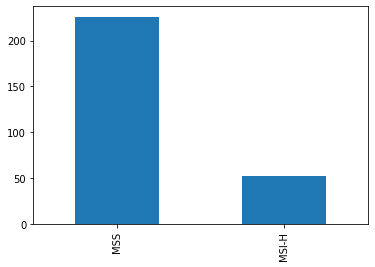

In [5]:
df[df['Tumor Type'] == 'STAD']['MOSAIC classification'].value_counts().plot(kind="bar")

In [6]:
f = lambda x: x[0:3]
msi_mask = (df['MOSAIC classification'] == 'MSI-H') & (df['Tumor Type'] == 'STAD')
mss_mask = (df['MOSAIC classification'] == 'MSS') & (df['Tumor Type'] == 'STAD')

msi_patient_id = df['Sample Name'][msi_mask].to_frame()
mss_patient_id = df['Sample Name'][mss_mask].to_frame()

msi_patient_id['microsatellite'] = 'MSI-H'
mss_patient_id['microsatellite'] = 'MSS'

microsatellite_label_df = msi_patient_id.append(mss_patient_id)

In [7]:
data = pd.read_csv("TCGA.Kallisto.fullIDs.cibersort.relative.tsv", sep="\t")
data["SampleID"] = data["SampleID"].apply(lambda x: x.replace('.', '-'))
data["PatientID"] = data["SampleID"].apply(lambda x: '-'.join(x.split('-')[0:3]))

In [8]:
data = data.merge(microsatellite_label_df, left_on="PatientID", right_on='Sample Name')

In [9]:
leuk = pd.read_csv("TCGA_all_leuk_estimate.masked.20170107.tsv", sep="\t", header=None)
leuk.columns = ['CancerType', 'SampleID', 'LF']
leuk.loc[leuk.LF < 0, 'LF'] = 0

id1 = set(data['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4] + [x.split('-')[4][0:2]])))
id2 = set(leuk['SampleID'].apply(lambda x: '-'.join(x.split('-')[0:4] + [x.split('-')[4][0:2]])))
common_id = id1.intersection(id2)
{
    '1': len(id1),
    '2': len(id2),
    'intersection': len(common_id)
}

{'1': 278, '2': 10782, 'intersection': 258}

In [10]:
merged = pd.DataFrame()
for id in common_id:
    temp = data[data['SampleID'].apply(lambda x: id in x)]
    temp.loc[:, 'LF'] = leuk.loc[leuk.loc[:, 'SampleID'].apply(lambda x: id in x), 'LF'].mean()
    merged = merged.append(temp.loc[temp.loc[:, 'P.value'].idxmax()])

/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/sliang3/miniconda3/envs/basic/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
merged

,B.cells.memory,B.cells.naive,CancerType,Correlation,Dendritic.cells.activated,Dendritic.cells.resting,Eosinophils,LF,Macrophages.M0,Macrophages.M1,...,Sample Name,SampleID,T.cells.CD4.memory.activated,T.cells.CD4.memory.resting,T.cells.CD4.naive,T.cells.CD8,T.cells.follicular.helper,T.cells.gamma.delta,T.cells.regulatory..Tregs.,microsatellite
19,0.006272,0.032931,STAD,0.048416,0.017037,0.000000,0.0,0.265837,0.062411,0.032548,...,TCGA-CG-5720,TCGA-CG-5720-01A-11R-1602-13,0.000000,0.134460,0.0,0.112382,0.069936,0.0,0.065460,MSS
8,0.016681,0.022968,STAD,0.096892,0.000000,0.034652,0.0,0.200074,0.018273,0.103393,...,TCGA-BR-4363,TCGA-BR-4363-01A-01R-1157-13,0.021835,0.210207,0.0,0.161970,0.069651,0.0,0.003337,MSI-H
38,0.000000,0.106345,STAD,0.136818,0.000000,0.036514,0.0,0.283408,0.011274,0.108372,...,TCGA-CD-8524,TCGA-CD-8524-01A-11R-2343-13,0.000000,0.137683,0.0,0.202292,0.053681,0.0,0.087023,MSS
59,0.034334,0.157616,STAD,0.220512,0.000000,0.000000,0.0,0.281674,0.017674,0.065480,...,TCGA-BR-8297,TCGA-BR-8297-01A-12R-2343-13,0.001024,0.231684,0.0,0.121642,0.067125,0.0,0.025424,MSS
247,0.224951,0.037927,STAD,0.321146,0.028433,0.000000,0.0,0.288441,0.016747,0.000000,...,TCGA-IN-AB1V,TCGA-IN-AB1V-01A-21R-A414-31,0.000000,0.172329,0.0,0.219316,0.035690,0.0,0.036212,MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.000000,0.060193,STAD,0.116255,0.013078,0.012991,0.0,0.369619,0.030365,0.100900,...,TCGA-ZQ-A9CR,TCGA-ZQ-A9CR-01A-11R-A39E-31,0.045388,0.157059,0.0,0.156671,0.039984,0.0,0.004552,MSS
234,0.000000,0.165186,STAD,0.246908,0.000000,0.000000,0.0,0.432474,0.204178,0.096617,...,TCGA-VQ-AA6J,TCGA-VQ-AA6J-01A-11R-A414-31,0.000505,0.124137,0.0,0.049985,0.112097,0.0,0.051282,MSS
117,0.000000,0.126505,STAD,0.259994,0.000000,0.000000,0.0,0.385624,0.108175,0.053362,...,TCGA-CD-5804,TCGA-CD-5804-01A-12R-2055-13,0.000000,0.118916,0.0,0.089690,0.013416,0.0,0.081640,MSS
208,0.053545,0.006316,STAD,0.106576,0.000000,0.055606,0.0,0.340575,0.026119,0.095537,...,TCGA-VQ-A91Y,TCGA-VQ-A91Y-01A-11R-A414-31,0.000000,0.216472,0.0,0.124199,0.013949,0.0,0.082414,MSS


In [12]:
for row_name in cell_types:
    merged[row_name] *= merged['LF']
merged

,B.cells.memory,B.cells.naive,CancerType,Correlation,Dendritic.cells.activated,Dendritic.cells.resting,Eosinophils,LF,Macrophages.M0,Macrophages.M1,...,Sample Name,SampleID,T.cells.CD4.memory.activated,T.cells.CD4.memory.resting,T.cells.CD4.naive,T.cells.CD8,T.cells.follicular.helper,T.cells.gamma.delta,T.cells.regulatory..Tregs.,microsatellite
19,0.001667,0.008754,STAD,0.048416,0.004529,0.000000,0.0,0.265837,0.016591,0.008652,...,TCGA-CG-5720,TCGA-CG-5720-01A-11R-1602-13,0.000000,0.035744,0.0,0.029875,0.018592,0.0,0.017402,MSS
8,0.003338,0.004595,STAD,0.096892,0.000000,0.006933,0.0,0.200074,0.003656,0.020686,...,TCGA-BR-4363,TCGA-BR-4363-01A-01R-1157-13,0.004369,0.042057,0.0,0.032406,0.013935,0.0,0.000668,MSI-H
38,0.000000,0.030139,STAD,0.136818,0.000000,0.010348,0.0,0.283408,0.003195,0.030713,...,TCGA-CD-8524,TCGA-CD-8524-01A-11R-2343-13,0.000000,0.039020,0.0,0.057331,0.015214,0.0,0.024663,MSS
59,0.009671,0.044396,STAD,0.220512,0.000000,0.000000,0.0,0.281674,0.004978,0.018444,...,TCGA-BR-8297,TCGA-BR-8297-01A-12R-2343-13,0.000289,0.065259,0.0,0.034263,0.018907,0.0,0.007161,MSS
247,0.064885,0.010940,STAD,0.321146,0.008201,0.000000,0.0,0.288441,0.004830,0.000000,...,TCGA-IN-AB1V,TCGA-IN-AB1V-01A-21R-A414-31,0.000000,0.049707,0.0,0.063260,0.010294,0.0,0.010445,MSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.000000,0.022248,STAD,0.116255,0.004834,0.004802,0.0,0.369619,0.011224,0.037295,...,TCGA-ZQ-A9CR,TCGA-ZQ-A9CR-01A-11R-A39E-31,0.016776,0.058052,0.0,0.057909,0.014779,0.0,0.001682,MSS
234,0.000000,0.071439,STAD,0.246908,0.000000,0.000000,0.0,0.432474,0.088302,0.041784,...,TCGA-VQ-AA6J,TCGA-VQ-AA6J-01A-11R-A414-31,0.000218,0.053686,0.0,0.021617,0.048479,0.0,0.022178,MSS
117,0.000000,0.048783,STAD,0.259994,0.000000,0.000000,0.0,0.385624,0.041715,0.020578,...,TCGA-CD-5804,TCGA-CD-5804-01A-12R-2055-13,0.000000,0.045857,0.0,0.034587,0.005173,0.0,0.031482,MSS
208,0.018236,0.002151,STAD,0.106576,0.000000,0.018938,0.0,0.340575,0.008895,0.032537,...,TCGA-VQ-A91Y,TCGA-VQ-A91Y-01A-11R-A414-31,0.000000,0.073725,0.0,0.042299,0.004751,0.0,0.028068,MSS


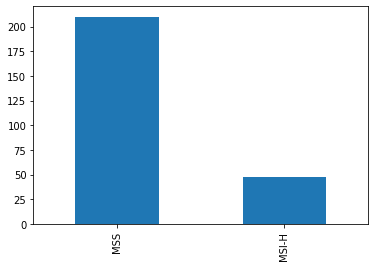

In [13]:
merged.microsatellite.value_counts().plot(kind="bar")

In [14]:


#merged['Leukocytes.all'] = merged[cell_types].sum(1)

merged['T.cells.all'] = merged[['T.cells.CD8',
                                    'T.cells.CD4.naive',
                                    'T.cells.CD4.memory.resting',
                                    'T.cells.CD4.memory.activated',
                                    'T.cells.follicular.helper',
                                    'T.cells.regulatory..Tregs.',
                                    'T.cells.gamma.delta']].sum(1)

merged['B.cells.all'] = merged[['B.cells.naive', 'B.cells.memory']].sum(1)

merged['Nk.cells.all'] = merged[['NK.cells.resting', 'NK.cells.activated']].sum(1)

merged['Macrophages.all'] = merged[['Macrophages.M0', 'Macrophages.M1', 'Macrophages.M2']].sum(1)

merged['Dendritic.cells.all'] = merged[['Dendritic.cells.resting', 'Dendritic.cells.activated']].sum(1)

merged['Mast.cells.all'] = merged[['Mast.cells.resting', 'Mast.cells.activated']].sum(1)



augmented_cell_types = cell_types + ['T.cells.all', 'B.cells.all', 'Nk.cells.all', 'Macrophages.all', 
                                     'Dendritic.cells.all', 'Mast.cells.all']

merged

,B.cells.memory,B.cells.naive,CancerType,Correlation,Dendritic.cells.activated,Dendritic.cells.resting,Eosinophils,LF,Macrophages.M0,Macrophages.M1,...,T.cells.follicular.helper,T.cells.gamma.delta,T.cells.regulatory..Tregs.,microsatellite,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
19,0.001667,0.008754,STAD,0.048416,0.004529,0.000000,0.0,0.265837,0.016591,0.008652,...,0.018592,0.0,0.017402,MSS,0.101613,0.010421,0.006724,0.058525,0.004529,0.048202
8,0.003338,0.004595,STAD,0.096892,0.000000,0.006933,0.0,0.200074,0.003656,0.020686,...,0.013935,0.0,0.000668,MSI-H,0.093434,0.007933,0.005773,0.064952,0.006933,0.010576
38,0.000000,0.030139,STAD,0.136818,0.000000,0.010348,0.0,0.283408,0.003195,0.030713,...,0.015214,0.0,0.024663,MSS,0.136228,0.030139,0.001943,0.089875,0.010348,0.010749
59,0.009671,0.044396,STAD,0.220512,0.000000,0.000000,0.0,0.281674,0.004978,0.018444,...,0.018907,0.0,0.007161,MSS,0.125880,0.054067,0.012213,0.049438,0.000000,0.034086
247,0.064885,0.010940,STAD,0.321146,0.008201,0.000000,0.0,0.288441,0.004830,0.000000,...,0.010294,0.0,0.010445,MSS,0.133706,0.075825,0.019692,0.014337,0.008201,0.012536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,0.000000,0.022248,STAD,0.116255,0.004834,0.004802,0.0,0.369619,0.011224,0.037295,...,0.014779,0.0,0.001682,MSS,0.149198,0.022248,0.019896,0.082322,0.009636,0.060110
234,0.000000,0.071439,STAD,0.246908,0.000000,0.000000,0.0,0.432474,0.088302,0.041784,...,0.048479,0.0,0.022178,MSS,0.146179,0.071439,0.006812,0.190461,0.000000,0.011640
117,0.000000,0.048783,STAD,0.259994,0.000000,0.000000,0.0,0.385624,0.041715,0.020578,...,0.005173,0.0,0.031482,MSS,0.117100,0.048783,0.015366,0.147997,0.000000,0.007603
208,0.018236,0.002151,STAD,0.106576,0.000000,0.018938,0.0,0.340575,0.008895,0.032537,...,0.004751,0.0,0.028068,MSS,0.148843,0.020387,0.025764,0.101854,0.018938,0.013968


In [15]:
mss = merged[merged.microsatellite == 'MSS'][augmented_cell_types]
msi = merged[merged.microsatellite == 'MSI-H'][augmented_cell_types]

In [16]:
mss

,B.cells.naive,B.cells.memory,Plasma.cells,T.cells.CD8,T.cells.CD4.naive,T.cells.CD4.memory.resting,T.cells.CD4.memory.activated,T.cells.follicular.helper,T.cells.regulatory..Tregs.,T.cells.gamma.delta,...,Mast.cells.resting,Mast.cells.activated,Eosinophils,Neutrophils,T.cells.all,B.cells.all,Nk.cells.all,Macrophages.all,Dendritic.cells.all,Mast.cells.all
19,0.008754,0.001667,0.000000,0.029875,0.0,0.035744,0.000000,0.018592,0.017402,0.0,...,0.000000,0.048202,0.000000,0.012190,0.101613,0.010421,0.006724,0.058525,0.004529,0.048202
38,0.030139,0.000000,0.002637,0.057331,0.0,0.039020,0.000000,0.015214,0.024663,0.0,...,0.001944,0.008805,0.000000,0.000000,0.136228,0.030139,0.001943,0.089875,0.010348,0.010749
59,0.044396,0.009671,0.000000,0.034263,0.0,0.065259,0.000289,0.018907,0.007161,0.0,...,0.034086,0.000000,0.000000,0.000000,0.125880,0.054067,0.012213,0.049438,0.000000,0.034086
247,0.010940,0.064885,0.006602,0.063260,0.0,0.049707,0.000000,0.010294,0.010445,0.0,...,0.012536,0.000000,0.000000,0.001473,0.133706,0.075825,0.019692,0.014337,0.008201,0.012536
253,0.001330,0.000000,0.001543,0.013664,0.0,0.003977,0.011974,0.011752,0.000000,0.0,...,0.000000,0.004498,0.000000,0.000491,0.041367,0.001330,0.006266,0.028929,0.000415,0.004498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.001103,0.000000,0.000293,0.003518,0.0,0.004073,0.000327,0.000000,0.000299,0.0,...,0.000000,0.001008,0.003273,0.000549,0.008218,0.001103,0.000421,0.007234,0.000086,0.001008
188,0.022248,0.000000,0.012270,0.057909,0.0,0.058052,0.016776,0.014779,0.001682,0.0,...,0.000000,0.060110,0.000000,0.000000,0.149198,0.022248,0.019896,0.082322,0.009636,0.060110
234,0.071439,0.000000,0.005944,0.021617,0.0,0.053686,0.000218,0.048479,0.022178,0.0,...,0.011640,0.000000,0.000000,0.000000,0.146179,0.071439,0.006812,0.190461,0.000000,0.011640
117,0.048783,0.000000,0.025725,0.034587,0.0,0.045857,0.000000,0.005173,0.031482,0.0,...,0.000000,0.007603,0.000000,0.008514,0.117100,0.048783,0.015366,0.147997,0.000000,0.007603


# Results

## MSS

In [17]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_mss = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = mss.shape[0];

# Mean
res_mss['mean'] = mss.mean(axis=0)

res_mss['sd'] = mss.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_mss['sd'] / np.sqrt(n)
res_mss['mean lower'] = (res_mss['mean'] - err).apply(sanitize)
res_mss['mean upper'] = (res_mss['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_mss['sd lower'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_mss['sd upper'] = np.sqrt((n - 1) * res_mss['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_mss

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.021841,0.017722,0.025960,0.030280,0.027635,0.033490
B.cells.memory,0.012122,0.008862,0.015382,0.023964,0.021870,0.026505
Plasma.cells,0.009863,0.007970,0.011755,0.013912,0.012697,0.015387
T.cells.CD8,0.032514,0.028686,0.036343,0.028145,0.025686,0.031129
T.cells.CD4.naive,0.000264,0.000000,0.000761,0.003657,0.003337,0.004044
T.cells.CD4.memory.resting,0.042240,0.037978,0.046501,0.031326,0.028590,0.034647
T.cells.CD4.memory.activated,0.003501,0.002222,0.004780,0.009404,0.008582,0.010401
T.cells.follicular.helper,0.016661,0.014615,0.018707,0.015039,0.013725,0.016633
T.cells.regulatory..Tregs.,0.012187,0.010680,0.013694,0.011080,0.010112,0.012255
T.cells.gamma.delta,0.000081,0.000000,0.000209,0.000943,0.000861,0.001043


## MSI

In [18]:
a = 0.05

sanitize = lambda x: 0.0 if x < 0 else 1.0 if x > 1 else x

res_msi = pd.DataFrame(index = cell_types, columns = ['mean', 'mean lower', 'mean upper', 'sd', 'sd lower', 'sd upper'])

n = msi.shape[0];

# Mean
res_msi['mean'] = msi.mean(axis=0)

res_msi['sd'] = msi.std(ddof=1, axis=0)
        
# Mean CI
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * res_msi['sd'] / np.sqrt(n)
res_msi['mean lower'] = (res_msi['mean'] - err).apply(sanitize)
res_msi['mean upper'] = (res_msi['mean'] + err).apply(sanitize)
        
# Standard deviation CI
res_msi['sd lower'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(1 - a / 2, n - 1))
res_msi['sd upper'] = np.sqrt((n - 1) * res_msi['sd'] ** 2 / scipy.stats.chi2.ppf(a / 2, n - 1))

res_msi

,mean,mean lower,mean upper,sd,sd lower,sd upper
B.cells.naive,0.013590,0.008455,0.018726,0.017686,0.014723,0.022153
B.cells.memory,0.003320,0.001454,0.005187,0.006428,0.005351,0.008051
Plasma.cells,0.007061,0.003206,0.010917,0.013279,0.011054,0.016632
T.cells.CD8,0.035222,0.026953,0.043491,0.028477,0.023706,0.035669
T.cells.CD4.naive,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
T.cells.CD4.memory.resting,0.034777,0.027812,0.041743,0.023987,0.019969,0.030046
T.cells.CD4.memory.activated,0.012378,0.007083,0.017673,0.018235,0.015180,0.022840
T.cells.follicular.helper,0.018723,0.014393,0.023054,0.014915,0.012416,0.018682
T.cells.regulatory..Tregs.,0.008790,0.005831,0.011750,0.010192,0.008485,0.012766
T.cells.gamma.delta,0.000093,0.000000,0.000276,0.000631,0.000525,0.000790


## Figures

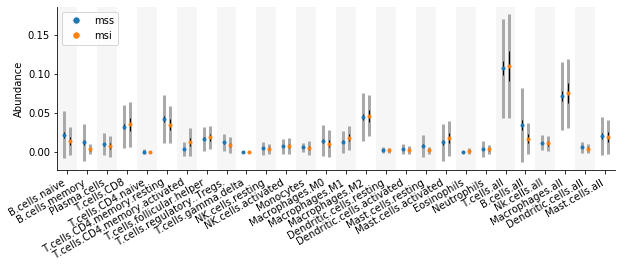

In [19]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 'mss': -0.15,
 'msi': 0.15}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {'mss': colors[0],
 'msi': colors[1]}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

n = mss.shape[0];
mean = mss.mean(axis=0)
sd = mss.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['mss'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['mss'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['mss'], ecolor = 'black', elinewidth=1.0)

n = msi.shape[0];
mean = msi.mean(axis=0)
sd = msi.std(ddof=1, axis=0)
err = scipy.stats.t.ppf(1 - a / 2, n - 1) * sd / np.sqrt(n)

x = [v + offset_map['msi'] for v in x_map.values()]
    
ax.errorbar(x, mean, yerr=sd, fmt='.', color = color_map['msi'], ecolor = 'darkgray', elinewidth=3.0)
ax.errorbar(x, mean, yerr=err, fmt="None", color = color_map['msi'], ecolor = 'black', elinewidth=1.0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')

In [20]:
len(cell_types)

22

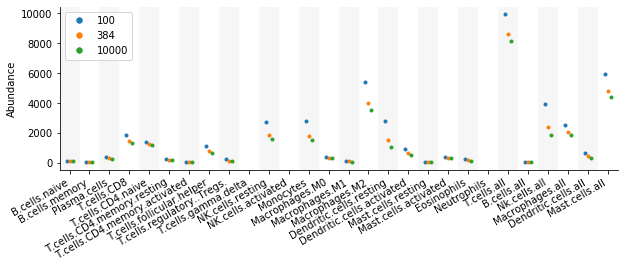

In [21]:
x_map = {v: i for i, v in enumerate(augmented_cell_types)}

offset_map = {
 100: -0.15,
 384: -0.0,
 10000: 0.15}

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

color_map = {
 100: colors[0],
 384: colors[1],
 10000: colors[2]}

fig = plt.figure(figsize=(10, 3))

ax = fig.add_subplot(1, 1, 1)

mss_n = mss.shape[0];
mss_mean = mss.mean(axis=0)
mss_sd = mss.std(ddof=1, axis=0)
mss_err = scipy.stats.t.ppf(1 - a / 2, mss_n - 1) * mss_sd / np.sqrt(mss_n)

msi_n = msi.shape[0];
msi_mean = msi.mean(axis=0)
msi_sd = msi.std(ddof=1, axis=0)
msi_err = scipy.stats.t.ppf(1 - a / 2, msi_n - 1) * msi_sd / np.sqrt(msi_n)

for cell_number in offset_map:
    x = [v + offset_map[cell_number] for v in x_map.values()]
    y = [sensei.optimize.find_minimum_M(10000, cell_number, [m0, m1], [s0, s1], beta=0.2, design='unpaired') for m0, m1, s0, s1 in zip(mss_mean, msi_mean, mss_sd, msi_sd)]    
    ax.errorbar(x, y, yerr=0, fmt='.', color = color_map[cell_number], ecolor = 'darkgray', elinewidth=3.0)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

current_ylim = ax.get_ylim()
for v in x_map.values():
    if v % 2 == 0:
        ax.fill_between([v - 0.5, v + 0.5], current_ylim[0], current_ylim[1], facecolor='lightgray', alpha=0.2)

ax.set_ylim(current_ylim)
ax.set_xticks(list(x_map.values()))
ax.tick_params(axis='x', which = 'both', labelbottom=None)
ax.set_ylabel('Abundance')
ax.set_xlim(-0.5, len(x_map) - 0.5)
    
# Ticks
ax.tick_params(axis='x', which = 'both', labelbottom=True)
ax.set_xticks(list(x_map.values()))
ax.set_xticklabels(list(x_map.keys()), rotation=30, ha='right')

legend_elements = [mpl.lines.Line2D([0], [0], marker='.', color='w', markerfacecolor=color_map[i], label=i, markersize=15) 
                   for i in color_map]

ax.legend(handles=legend_elements, loc='upper left')